We need to :

1. generate data
2. define priors in lim space
3. do inference in limited space
4. in inference expand space for update
5. shrink back for global update 
6. repeat till convergence

Stuff thats different :

Dirichlet(a_11 , ... , a_1n )= Dirichlet (a_12, ... ,a_1N) i.e. the diagonal entry of the transition matrix is set to 0 


/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


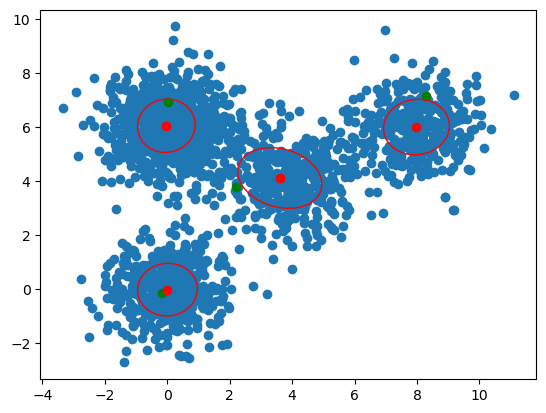

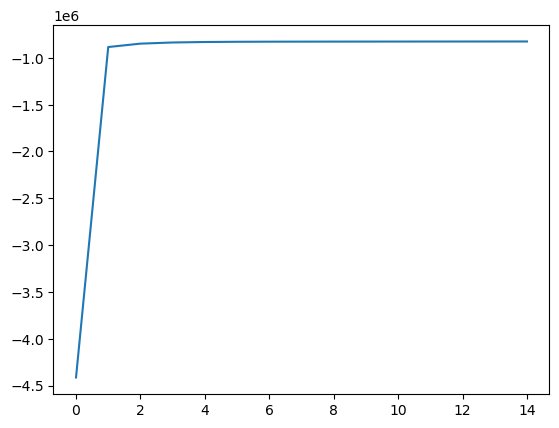

In [1]:
from test_hsmmbatchcd import *

for i in range(1):
    test_hsmmbatchcd()

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from pybasicbayes.distributions import Gaussian
from sklearn.cluster import KMeans

In [3]:
centers = np.array([np.array([0,0]),np.array([4,4]),np.array([0,6]),np.array([8,6])])


K = 4           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 1.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0 ,0.3,0.6,0.1],
    [0.2, 0 ,0.7,0.1],
    [0.7,0.2, 0 ,0.1],
    [0.7,0.2,0.1, 0 ]
    ])

N = 2000
lambda_js = np.arange(1,K+1)*2 + 2


from generate_data import *
emit = make_emissions(centers , kappa_0, nu_0)

seq_hsmm, ind = generate_states_pois(T,lambda_js,N)

obs_hsmm = generate_data(emit,ind)

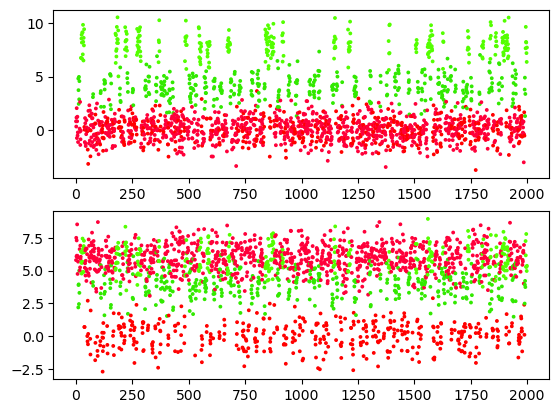

In [4]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm ,cmap = 'prism')
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm ,cmap = 'prism')

In [5]:
kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs_hsmm.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emissions for each super state
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_A = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
np.fill_diagonal(prior_A, 0)

prior_pi0 = np.ones(K)                     # ?
# -----------------------------------------------------------------
# page break
m_js,lambda_js = np.ones(K)*10, np.array(lambda_js)



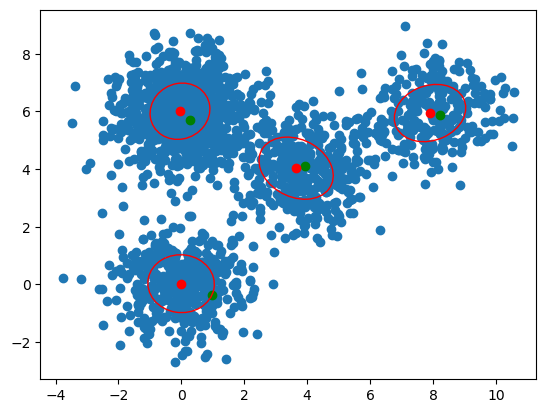

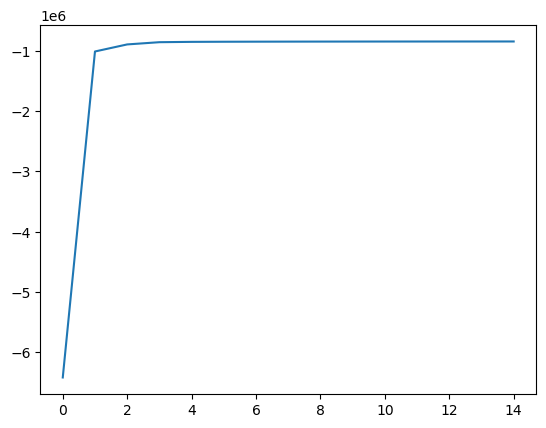

In [6]:
import hsmmbatchcd as HSMM
import util
from scipy.stats import invwishart,t,beta

# define object for inferrence from hmmbatchcd.py
# # pass priors on init transitions and emissions for each state
hsmm = HSMM.VBHSMM(obs_hsmm, prior_pi0, prior_A, prior_emit,m_js,lambda_js,maxit=15, epsilon=10**(-10))  
hsmm.infer() # do inference 
sts_true = seq_hsmm # true states 
# hamming distance
##print(prior_emit[0].mu_mf)
##print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs_hsmm, prior_emit, hsmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hsmm.elbo_vec)
plt.show()

In [7]:
VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hsmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]

for i in range(0,len(hsmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hsmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hsmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hsmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hsmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hsmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hsmm.var_A[i][j]

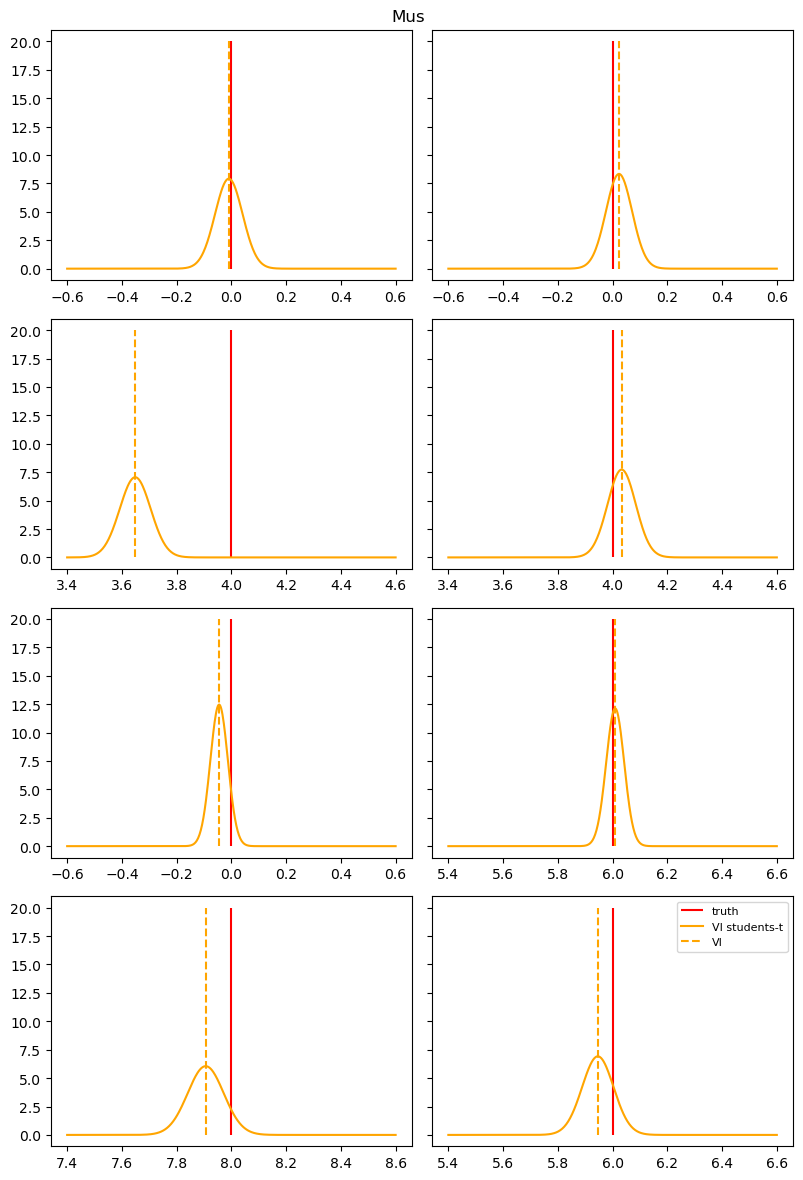

In [8]:
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'red',label='truth')
        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI students-t',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')

        # plt.ylim((0,20))
plt.suptitle('Mus')
plt.legend(fontsize = 8)
plt.tight_layout()


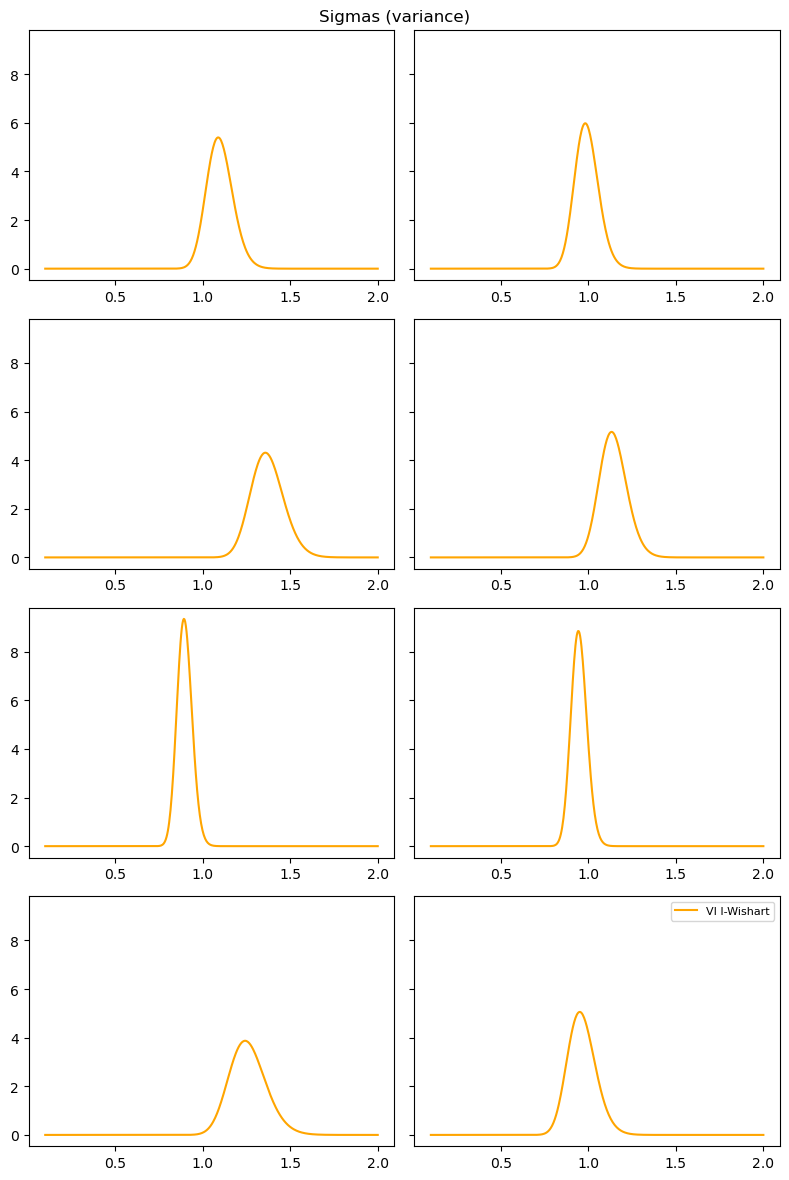

In [9]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        # ax.vlines(1,0,10,color = 'red',label='truth')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigmas (variance)')
plt.legend(fontsize = 8)
plt.tight_layout()

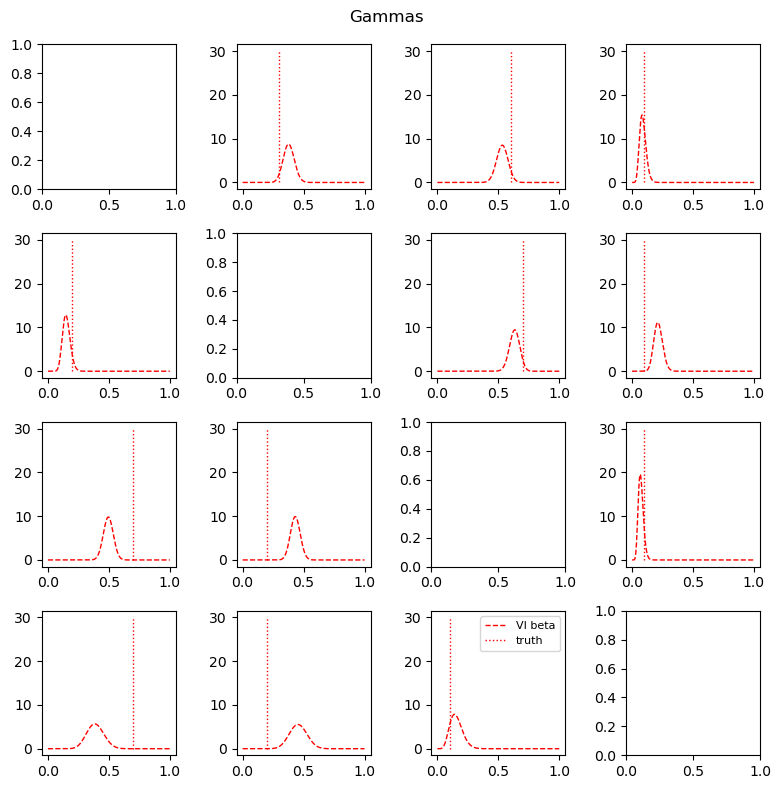

In [10]:
K=4
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        if k==j:
            pass
        else:
            ax = axs[k,j]
            x = np.linspace(0,1,500)
            dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist,label = 'VI beta',color = 'red',linewidth=1.0,linestyle = 'dashed')
            ax.vlines(T[k][j],0,30,color = 'red',label='truth',linewidth=1.0,linestyle = 'dotted')

            # ax.set_xlim(0,1)
            ax.set(ylabel=None)
        if k==(K-1):
            if j==(K-2):
                ax.legend(['VI beta', 'truth'], fontsize=8)



plt.suptitle('Gammas')
plt.tight_layout()
plt.show()